In [1]:
from getSents import getTrainDocsAndRels, getDevDocsAndRels, getTestDocsAndRels, getTrainSentListAndIndex, getDevSentListAndIndex, getTestSentListAndIndex
from scienceie_loader import get_entity_span_from_B_index

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib
number of training documents: 350
number of dev documents: 50
number of test documents: 100
Total number of training relations = 680
Total number of dev relations = 168
Total number of test relations = 196


In [2]:
# get docs and relations
trainDocs, trainRelations = getTrainDocsAndRels()
devDocs, devRelations = getDevDocsAndRels()
testDocs, testRelations = getTestDocsAndRels()

In [3]:
# get docs in sentences and the index of every doc
trainSentList, trainDocToSentIndex = getTrainSentListAndIndex()
devSentList, devDocToSentIndex = getDevSentListAndIndex()
testSentList, testDocToSentIndex = getTestSentListAndIndex()

In [4]:
allSentences = trainSentList + devSentList + testSentList

In [5]:
tempTrainingEntities = []
for sent in allSentences:
    words = []
    wordTag = ""
    entityBoolean = False
    for word, tag in sent:
        if tag[:2] == "B-":
            wordTag = tag[2:]
            words.append(word)
            entityBoolean = True
            continue
        if entityBoolean:
            if tag[:2] == "B-":
                tempTrainingEntities.append(" ".join(words))
                words = []
                wordTag = tag
                words.append(word)
            elif tag == "I-" + wordTag:
                words.append(word)
            else:
                tempTrainingEntities.append(" ".join(words))
                words = []
                wordTag = ""
                entityBoolean = False

In [6]:
lenOfTempTrainingEntities = np.sort(np.unique([len(entity.split(" ")) for entity in tempTrainingEntities])).tolist()

In [7]:
numberOfEntitiesByLen = []
for i in range(lenOfTempTrainingEntities[0], lenOfTempTrainingEntities[-1] + 1):
    tempEntitiesByLen = []
    for entity in tempTrainingEntities:
        if len(entity.split(" ")) == i:
            tempEntitiesByLen.append(entity)
    numberOfEntitiesByLen.append(len(tempEntitiesByLen))

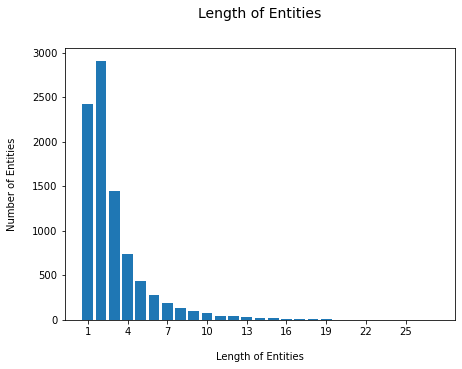

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt00, ax00 = plt.subplots(figsize = (7, 5))
ax00.bar(range(lenOfTempTrainingEntities[0], lenOfTempTrainingEntities[-1] + 1), numberOfEntitiesByLen)
ax00.set_title("Length of Entities", size = 14, pad = 30)
ax00.set_ylabel("Number of Entities", labelpad = 15)
ax00.set_xlabel("Length of Entities", labelpad = 15)
trash = ax00.set_xticks(range(lenOfTempTrainingEntities[0], lenOfTempTrainingEntities[-1] + 1, 3))
plt00.savefig("./CourseworkPlots/lengthOfEntities.png")

In [9]:
entitiesCounter = []
for i in range(4):
    entitiesCounter.append(0)
    
for sentence in allSentences:
    for word, tag in sentence:
        if tag == "B-Task":
            entitiesCounter[0] = entitiesCounter[0] + 1
            entitiesCounter[1] = entitiesCounter[1] + 1
        elif tag == "B-Process":
            entitiesCounter[0] = entitiesCounter[0] + 1
            entitiesCounter[2] = entitiesCounter[2] + 1
        elif tag == "B-Material":
            entitiesCounter[0] = entitiesCounter[0] + 1
            entitiesCounter[3] = entitiesCounter[3] + 1

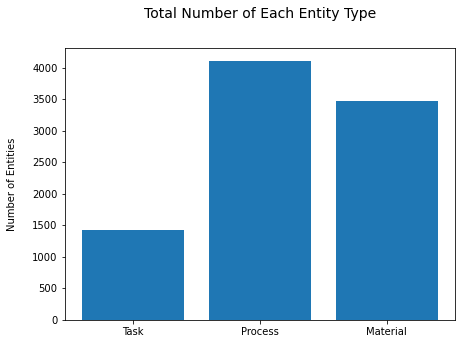

In [10]:
plt000, ax000 = plt.subplots(figsize = (7, 5))
ax000.bar(range(0, 3), entitiesCounter[1:])
ax000.set_title("Total Number of Each Entity Type", size = 14, pad = 30)
ax000.set_ylabel("Number of Entities", labelpad = 15)
trash = ax000.set_xticks(range(0, 3))
trash = ax000.set_xticklabels(["Task", "Process", "Material"])
plt000.savefig("./CourseworkPlots/totalNumberOfEachEntityType.png")

In [11]:
def extract_spans(tagged_sents, ne_tags):
    
    spans = {}
    for ne_tag in ne_tags:
        if ne_tag == 'O':
            continue

        spans[ne_tag[2:]] = []  # create an empty list to store the spans of each type
        
    for sidx, sent in enumerate(tagged_sents):
        start = -1
        entity_type = None
        for i, (tok, lab) in enumerate(sent):
            if 'B-' in lab:
                start = i
                end = i + 1
                entity_type = lab[2:]
            elif 'I-' in lab:
                end = i + 1
            elif lab == 'O' and start >= 0:
                spans[entity_type].append((start, end, sidx))
                start = -1
                
    return spans


def calculateF1(test_sents, test_sents_with_pred, ne_tags):
    # get a list of spans from the test set labels
    gold_spans = extract_spans(test_sents, ne_tags)
    
    # get a list of spans predicted by our tagger
    pred_spans = extract_spans(test_sents_with_pred, ne_tags)
    
    # compute the metrics for each class:
    f1_per_class = []
    
    ne_types = gold_spans.keys()  # get the list of named entity types (not the tags)
    
    for ne_type in ne_types:
        # compute the confusion matrix
        true_pos = 0
        false_pos = 0
    
        for span in pred_spans[ne_type]:
            if span in gold_spans[ne_type]:
                true_pos += 1
            else:
                false_pos += 1
                
        false_neg = 0
        for span in gold_spans[ne_type]:
            if span not in pred_spans[ne_type]:
                false_neg += 1
                
        if true_pos + false_pos == 0:
            precision = 0
        else:
            precision = true_pos / float(true_pos + false_pos)
            
        if true_pos + false_neg == 0:
            recall = 0
        else:
            recall = true_pos / float(true_pos + false_neg)
        
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
            
        f1_per_class.append(f1)
        print(f'F1 score for class {ne_type} = {f1}')
        
    print(f'Macro-average f1 score = {np.mean(f1_per_class)}')
    
    return np.mean(f1_per_class)
    
    
# some code to print out errors made by one of the sequence taggers. 
def printErrors(sentList, predList):
    window_size = 3
    for i, sent in enumerate(sentList):
        token_shown = -1

        for j, (tok, label) in enumerate(sent):
            predicted_label = predList[i][j][1]

            if j < token_shown + window_size:
                continue

            token_shown = -1

            if label != predicted_label:
                start = j - window_size
                if start < 0:
                    start = 0

                end = j + window_size
                if end > len(sent):
                    end = len(sent)

                #print('Error found:')

                text = [tok for tok, lab in predList[i][start:end]]
                preds = [lab for tok, lab in predList[i][start:end]]
                gold = [lab for tok, lab in sent[start:end]]
                print(f'       Text: {text}')
                print(f' Prediction: {preds}')
                print(f'Gold labels: {gold}')
                print()

# Task 1: Extracting Entities from Scientific Abstracts

### 1.1.

The first method that we will use is a CRFTagger. We will test it on our dev data with unigrams, and pos tags.

In [12]:
import nltk
from nltk.tag import CRFTagger

# Train a CRF NER tagger
def train_CRF_NER_tagger(train_set):
    
    tagger = nltk.tag.CRFTagger()
    tagger.train(train_set, 'model.crf.tagger')
    
    return tagger  # return the trained model

In [13]:
# tag the test set
def tag_test_set(test_set, tagger):
    
    test_sents = [[token for token,tag in sent] for sent in test_set]
    predicted_tags = tagger.tag_sents(test_sents)
    
    return predicted_tags

In [14]:
# get all ner tags
nerTags = list(np.sort(np.unique([tag for trainDoc in trainDocs for word, tag in trainDoc])))
nerTags

['B-Material', 'B-Process', 'B-Task', 'I-Material', 'I-Process', 'I-Task', 'O']

In [15]:
taggerWithUnigramsForDocs = train_CRF_NER_tagger(trainDocs)

devPredsWithUnigramsForDocs = tag_test_set(devDocs, taggerWithUnigramsForDocs)

unigramsForDocsF1 = calculateF1(devDocs, devPredsWithUnigramsForDocs, nerTags)

F1 score for class Material = 0.22916666666666663
F1 score for class Process = 0.2113095238095238
F1 score for class Task = 0.11059907834101382
Macro-average f1 score = 0.18369175627240142


In [16]:
taggerWithUnigrams = train_CRF_NER_tagger(trainSentList)

devPredsWithUnigrams = tag_test_set(devSentList, taggerWithUnigrams)

unigramsF1 = calculateF1(devSentList, devPredsWithUnigrams, nerTags)

F1 score for class Material = 0.2346041055718475
F1 score for class Process = 0.22680412371134023
F1 score for class Task = 0.14545454545454542
Macro-average f1 score = 0.20228759157924436


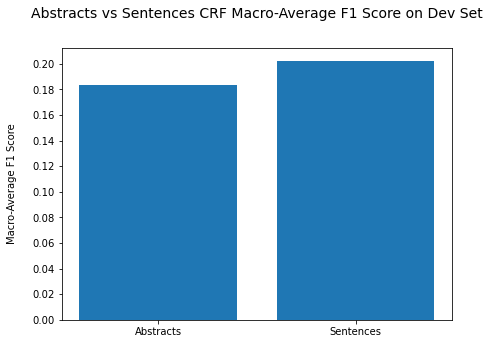

In [17]:
plt0, ax0 = plt.subplots(figsize = (7, 5))
ax0.bar([0, 1], [unigramsForDocsF1, unigramsF1])
ax0.set_title("Abstracts vs Sentences CRF Macro-Average F1 Score on Dev Set", size = 14, pad = 30)
ax0.set_ylabel("Macro-Average F1 Score", labelpad = 15)
ax0.set_yticks([y / 100 for y in range(0, 21, 2)])
ax0.set_xticks([0, 1])
trash = ax0.set_xticklabels(["Abstracts", "Sentences"])
plt0.savefig("./CourseworkPlots/differenceBetweenDocumentsAndSentences.png")

We will try to increase the performance of our algorithm by adding pos tags along with unigrams.

In [18]:
class CRFTaggerWithPOS(nltk.tag.CRFTagger):
    
    _current_tokens = None
    
    def _get_features(self, tokens, index):
        
        basic_features = super()._get_features(tokens, index)
        
        if tokens != self._current_tokens:
            self._pos_tagged_tokens = nltk.pos_tag(tokens)
            self._current_tokens = tokens
        
        basic_features.append(self._pos_tagged_tokens[index][1])
        
        return basic_features

def train_CRF_NER_tagger_POS(train_set):
    
    tagger = CRFTaggerWithPOS()
    tagger.train(train_set, 'model.crf.tagger')
    
    return tagger  # return the trained model

taggerWithPOS = train_CRF_NER_tagger_POS(trainSentList)

In [19]:
devPredsWithPOS = tag_test_set(devSentList, taggerWithPOS)

In [20]:
posF1 = calculateF1(devSentList, devPredsWithPOS, nerTags)

F1 score for class Material = 0.2655367231638418
F1 score for class Process = 0.27510316368638243
F1 score for class Task = 0.15384615384615385
Macro-average f1 score = 0.2314953468987927


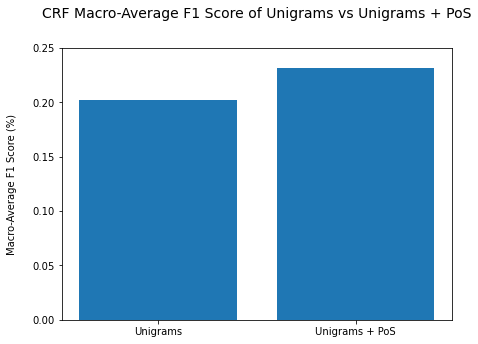

In [21]:
plt1, ax1 = plt.subplots(figsize = (7, 5))
ax1.bar([0, 1], [unigramsF1, posF1])
ax1.set_title("CRF Macro-Average F1 Score of Unigrams vs Unigrams + PoS", size = 14, pad = 30)
ax1.set_ylabel("Macro-Average F1 Score (%)", labelpad = 15)
ax1.set_yticks([y / 100 for y in range(0, 30, 5)])
ax1.set_xticks([0, 1])
trash = ax1.set_xticklabels(["Unigrams", "Unigrams + PoS"])
plt1.savefig("./CourseworkPlots/differenceBetweenUnigramsAndUnigramsAndPOS.png")

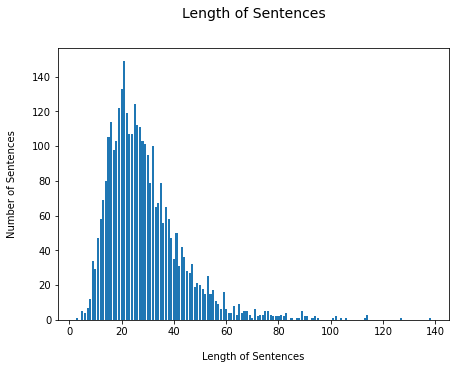

In [22]:
lenOfSentences = [len(sentence) for sentence in allSentences]
rangeOfSentences = []
rangeOfSentences.append(min(lenOfSentences))
rangeOfSentences.append(max(lenOfSentences))
numberOfSentencesByLen = []
for i in range(rangeOfSentences[0], rangeOfSentences[1] + 1):
    counter = 0
    for los in lenOfSentences:
        if i == los:
            counter += 1
    numberOfSentencesByLen.append(counter)

plt11, ax11 = plt.subplots(figsize = (7, 5))
ax11.bar(range(rangeOfSentences[0], rangeOfSentences[1] + 1), numberOfSentencesByLen)
ax11.set_title("Length of Sentences", size = 14, pad = 30)
ax11.set_ylabel("Number of Sentences", labelpad = 15)
ax11.set_xlabel("Length of Sentences", labelpad = 15)
trash = ax1.set_xticks(range(rangeOfSentences[0], rangeOfSentences[1] + 1, 10))
plt11.savefig("./CourseworkPlots/lengthOfSentences.png")

In [23]:
import tensorflow as tf
import keras 

tokenizer = tf.keras.preprocessing.text.Tokenizer(lower = False, filters = "")

allSentencesWithoutTags = []
for sentence in allSentences:
    tempSentence = []
    for word, tag in sentence:
        tempSentence.append(word)
    allSentencesWithoutTags.append(tempSentence)

tokenizer.fit_on_texts(allSentencesWithoutTags)

In [24]:
len(tokenizer.word_index) + 1

12010

In [25]:
encodedSentences = tokenizer.texts_to_sequences(allSentencesWithoutTags)
for i, sentence in enumerate(allSentences):
    if len(encodedSentences[i]) != len(sentence):
        print(i)

In [26]:
tagsMap = {t: i for i, t in enumerate(np.unique([tag for sentence in allSentences for word, tag in sentence]).tolist())}
tagsMap

{'B-Material': 0,
 'B-Process': 1,
 'B-Task': 2,
 'I-Material': 3,
 'I-Process': 4,
 'I-Task': 5,
 'O': 6}

In [27]:
reverseTagMap = {v: k for k, v in tagsMap.items()}
reverseTagMap

{0: 'B-Material',
 1: 'B-Process',
 2: 'B-Task',
 3: 'I-Material',
 4: 'I-Process',
 5: 'I-Task',
 6: 'O'}

In [28]:
allSentencesWithoutWords = []
for sentence in allSentences:
    tempSentence = []
    for word, tag in sentence:
        tempSentence.append(tag)
    allSentencesWithoutWords.append(tempSentence)
    
for i, sentence in enumerate(allSentences):
    if len(allSentencesWithoutWords[i]) != len(sentence):
        print(i)

In [29]:
encodedTags = [[tagsMap[tag] for tag in tagSent] for tagSent in allSentencesWithoutWords]

for i, sentence in enumerate(allSentences):
    if len(encodedTags[i]) != len(sentence):
        print(i)

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

maxLen = max([len(sentence) for sentence in allSentences])
maxLen

paddedEncodedSentences = pad_sequences(maxlen = maxLen, sequences = encodedSentences, padding = "post", value = 0)
paddedEncodedTags = pad_sequences(maxlen = maxLen, sequences = encodedTags, padding = "post", value = tagsMap["O"])

In [31]:
print(paddedEncodedSentences.shape, ":", paddedEncodedTags.shape)

(3359, 138) : (3359, 138)


In [32]:
target = [to_categorical(i, num_classes = len(tagsMap)) for i in paddedEncodedTags]
target[0].shape

(138, 7)

In [33]:
trainX = []
trainY = []
for i, sentence in enumerate(trainSentList):
    trainX.append(paddedEncodedSentences[i].tolist())
    trainY.append(target[i])

trainX = np.array(trainX)
trainY = np.array(trainY)

devX = []
devY = []
for i, sentence in enumerate(devSentList):
    devX.append(paddedEncodedSentences[i + len(trainSentList)].tolist())
    devY.append(target[i + len(trainSentList)])

devX = np.array(devX)
devY = np.array(devY)

testX = []
testY = []
for i, sentence in enumerate(testSentList):
    testX.append(paddedEncodedSentences[i + len(trainSentList) + len(devSentList)].tolist())
    testY.append(target[i + len(trainSentList) + len(devSentList)])
    
testX = np.array(testX)
testY = np.array(testY)

print(trainX.shape, len(trainY))
print(devX.shape, len(devY))
print(testX.shape, len(testY))
print(trainX[0].shape, trainY[0].shape)

(2244, 138) 2244
(367, 138) 367
(748, 138) 748
(138,) (138, 7)


In [34]:
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [35]:
embeddingDim = maxLen
vocabSize = len(tokenizer.word_index) + 1
lstmUnits = maxLen

inputWord = Input(shape = (maxLen, ))

model = Embedding(input_dim = vocabSize + 1, output_dim = embeddingDim, input_length = maxLen, mask_zero = True)(inputWord)

model = Bidirectional(LSTM(units = embeddingDim, return_sequences = True))(model)

out = TimeDistributed(Dense(len(tagsMap), activation = "softmax"))(model)

model = Model(inputWord, out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 138)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 138, 138)          1657518   
_________________________________________________________________
bidirectional (Bidirectional (None, 138, 276)          305808    
_________________________________________________________________
time_distributed (TimeDistri (None, 138, 7)            1939      
Total params: 1,965,265
Trainable params: 1,965,265
Non-trainable params: 0
_________________________________________________________________


In [36]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def shuffle_weights(model, weights=None):
    
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    
    model.set_weights(weights)
    
def getPredictions(sentList, preds):
    
    predY = np.argmax(preds, axis = 2)
    predTags = [[reverseTagMap[tag] for tag in predSent] for predSent in list(predY)]
    
    predSentList = []
    for i, sentence in enumerate(sentList):
        tempSent = []
        for j, (word, tag) in enumerate(sentence):
            tempSent.append((word, predTags[i][j]))
        predSentList.append(tempSent)
    
    return predSentList

In [37]:
history = []
nnPredSentList = []
nnF1 = []
for i, metric in enumerate(["accuracy", precision_m, recall_m, f1_m]):
    model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = [metric])
#     if i == 0:
#         model.save_weights("nnWeights.h5")
#         #initialWeights = model.get_weights()
#     else:
#         model.load_weights('nnWeights.h5')
#         #shuffle_weights(model, initialWeights)
    model.load_weights('nnWeights.h5')
    history.append(model.fit(trainX, trainY, validation_data = (devX, devY), batch_size = 32, epochs = 10, verbose = 0))
    preds = model.predict(devX)
    nnPredSentList.append(getPredictions(devSentList, preds))
    nnF1.append(calculateF1(devSentList, nnPredSentList[-1], list(np.sort(np.unique([tag for sentence in trainSentList for word, tag in sentence])))))

F1 score for class Material = 0.29977628635346754
F1 score for class Process = 0.21151271753681394
F1 score for class Task = 0.09478672985781991
Macro-average f1 score = 0.20202524458270046
F1 score for class Material = 0.25654450261780104
F1 score for class Process = 0.20170454545454544
F1 score for class Task = 0.12444444444444443
Macro-average f1 score = 0.19423116417226363
F1 score for class Material = 0.23243243243243245
F1 score for class Process = 0.20506912442396316
F1 score for class Task = 0.11206896551724137
Macro-average f1 score = 0.18319017412454563
F1 score for class Material = 0.23268698060941828
F1 score for class Process = 0.20023557126030622
F1 score for class Task = 0.09795918367346938
Macro-average f1 score = 0.17696057851439795


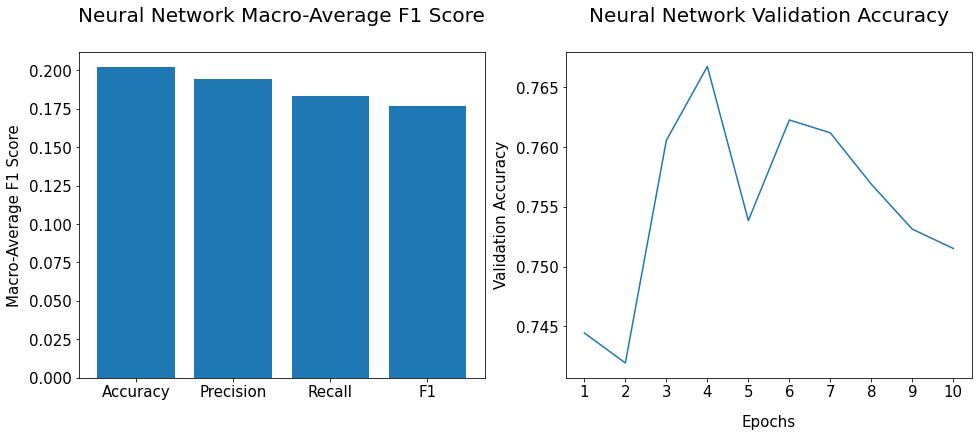

In [45]:
plt4, ax4 = plt.subplots(1, 2, figsize = (16, 6))

ax4[0].bar([0, 1, 2, 3], [nnF1[0], nnF1[1], nnF1[2], nnF1[3]])
ax4[0].set_title("Neural Network Macro-Average F1 Score", size = 20, pad = 30)
ax4[0].set_ylabel("Macro-Average F1 Score", size = 15, labelpad = 7)
#ax1.set_yticks([y / 100 for y in range(0, 30, 5)])
ax4[0].set_xticks([0, 1, 2, 3])
ax4[0].set_xticklabels(["Accuracy", "Precision", "Recall", "F1"], size = 15)
ax4[0].tick_params(axis = "y", labelsize = 15)

ax4[1].plot(history[0].history["val_accuracy"])
ax4[1].plot
ax4[1].set_title("Neural Network Validation Accuracy", size = 20, pad = 30)
ax4[1].set_ylabel("Validation Accuracy", size = 15, labelpad = 7)
ax4[1].set_xlabel("Epochs", size = 15, labelpad = 15)
#ax4[1].set_yticks([y / 1000 for y in range(780, 900, 20)])
ax4[1].set_xticks(range(0, 10))
ax4[1].tick_params(axis = "y", labelsize = 15)
trash = ax4[1].set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"], size = 15)
plt4.savefig("./CourseworkPlots/nnResultsOnDev.png")

### 1.2

In [46]:
taggerWithPOS = train_CRF_NER_tagger_POS(trainSentList)
testPredsWithPOS = tag_test_set(testSentList, taggerWithPOS)
testCRFF1 = calculateF1(testSentList, testPredsWithPOS, nerTags)

F1 score for class Material = 0.20868113522537562
F1 score for class Process = 0.2356202356202356
F1 score for class Task = 0.048484848484848485
Macro-average f1 score = 0.16426207311015323


In [47]:
# NN on test data
if nnF1.index(max(nnF1)) == 0: metric = "accuracy"
elif nnF1.index(max(nnF1)) == 1: metric = precision_m
elif nnF1.index(max(nnF1)) == 2: metric = recall_m
elif nnF1.index(max(nnF1)) == 3: metric = f1_m

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = [metric])
model.load_weights('nnWeights.h5')
history.append(model.fit(trainX, trainY, validation_data = (devX, devY), batch_size = 32, epochs = 10))
preds = model.predict(testX)
nnPredSentList.append(getPredictions(testSentList, preds))
nnF1.append(calculateF1(testSentList, nnPredSentList[-1], list(np.sort(np.unique([tag for sentence in trainSentList for word, tag in sentence])))))

Epoch 1/10
71/71 [==============================] - 14s 135ms/step - loss: 0.2883 - accuracy: 0.6781 - val_loss: 0.2080 - val_accuracy: 0.7445
Epoch 2/10
71/71 [==============================] - 8s 113ms/step - loss: 0.1976 - accuracy: 0.7116 - val_loss: 0.1761 - val_accuracy: 0.7536
Epoch 3/10
71/71 [==============================] - 8s 112ms/step - loss: 0.1586 - accuracy: 0.7388 - val_loss: 0.1646 - val_accuracy: 0.7582
Epoch 4/10
71/71 [==============================] - 8s 111ms/step - loss: 0.1305 - accuracy: 0.7834 - val_loss: 0.1611 - val_accuracy: 0.7623
Epoch 5/10
71/71 [==============================] - 8s 120ms/step - loss: 0.1095 - accuracy: 0.8278 - val_loss: 0.1666 - val_accuracy: 0.7635
Epoch 6/10
71/71 [==============================] - 8s 115ms/step - loss: 0.0801 - accuracy: 0.8734 - val_loss: 0.1710 - val_accuracy: 0.7574
Epoch 7/10
71/71 [==============================] - 8s 116ms/step - loss: 0.0596 - accuracy: 0.9088 - val_loss: 0.1935 - val_accuracy: 0.7620
Epoch

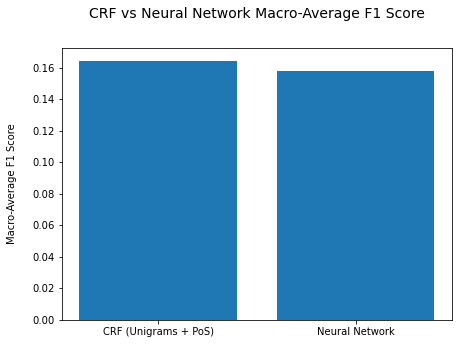

In [48]:
plt5, ax5 = plt.subplots(figsize = (7, 5))
ax5.bar([0, 1], [testCRFF1, nnF1[-1]])
ax5.set_title("CRF vs Neural Network Macro-Average F1 Score", size = 14, pad = 30)
ax5.set_ylabel("Macro-Average F1 Score", labelpad = 15)
ax5.set_xticks([0, 1])
trash = ax5.set_xticklabels(["CRF (Unigrams + PoS)", "Neural Network"])
plt5.savefig("./CourseworkPlots/crfvsNNResults.png")

In [49]:
printErrors(testSentList, testPredsWithPOS)

       Text: ['Prior', 'to', 'assembling', 'the', 'miniature']
 Prediction: ['O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'B-Task', 'I-Task', 'I-Task']

       Text: ['Prior', 'to', 'assembling', 'the', 'miniature', 'ADR']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'B-Process']
Gold labels: ['O', 'O', 'B-Task', 'I-Task', 'I-Task', 'I-Task']

       Text: ['to', 'assembling', 'the', 'miniature', 'ADR', ',']
 Prediction: ['O', 'O', 'O', 'O', 'B-Process', 'O']
Gold labels: ['O', 'B-Task', 'I-Task', 'I-Task', 'I-Task', 'O']

       Text: ['assembling', 'the', 'miniature', 'ADR', ',', 'the']
 Prediction: ['O', 'O', 'O', 'B-Process', 'O', 'O']
Gold labels: ['B-Task', 'I-Task', 'I-Task', 'I-Task', 'O', 'O']

       Text: ['not', 'be', 'fully', 'thermally', 'characterised', 'due']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Process', 'I-Process', 'O']

       Text: ['be', 'fully', 'thermally', 'characterised', 'due', 'to']
 Prediction: ['O', 'O', 'O', 'O', 'O', 

Gold labels: ['O', 'O', 'B-Process', 'I-Process', 'I-Process', 'I-Process']

       Text: ['the', 'creation', 'of', 'nm-sized', 'or', 'smaller']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']

       Text: ['creation', 'of', 'nm-sized', 'or', 'smaller', 'electron']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'B-Material']
Gold labels: ['B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']

       Text: ['of', 'nm-sized', 'or', 'smaller', 'electron', 'vortices']
 Prediction: ['O', 'O', 'O', 'O', 'B-Material', 'I-Material']
Gold labels: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']

       Text: ['nm-sized', 'or', 'smaller', 'electron', 'vortices', 'but']
 Prediction: ['O', 'O', 'O', 'B-Material', 'I-Material', 'O']
Gold labels: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'O']

       Text: ['or', 'smaller', 'electron', 'vortices', 'bu

 Prediction: ['B-Process', 'I-Process', 'O', 'O', 'O', 'O']
Gold labels: ['B-Process', 'O', 'O', 'B-Material', 'O', 'O']

       Text: ['polymers', 'with', 'precisely', 'controlled', 'chain', 'length']
 Prediction: ['O', 'O', 'O', 'B-Process', 'I-Process', 'I-Process']
Gold labels: ['B-Material', 'O', 'O', 'O', 'O', 'O']

       Text: ['with', 'precisely', 'controlled', 'chain', 'length', 'and']
 Prediction: ['O', 'O', 'B-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['precisely', 'controlled', 'chain', 'length', 'and', 'narrow']
 Prediction: ['O', 'B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['controlled', 'chain', 'length', 'and', 'narrow', 'molar']
 Prediction: ['B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['chain', 'length', 'and', 'narrow', 'molar', 'mass

 Prediction: ['I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['input-data', 'uncertainty', 'to', 'create', 'outputs', 'accompanied']
 Prediction: ['I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['uncertainty', 'to', 'create', 'outputs', 'accompanied', 'by']
 Prediction: ['I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['to', 'create', 'outputs', 'accompanied', 'by', 'probability']
 Prediction: ['I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['create', 'outputs', 'accompanied', 'by', 'probability', 'statements']
 Prediction: ['I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['outputs', 'accompanied', 'by', 'probability', 'statements', 'and']

Gold labels: ['O', 'O', 'B-Process', 'I-Process', 'O']

       Text: ['Hence', ',', 'the', 'crashworthiness', 'parameters', 'are']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'I-Material', 'O']

       Text: [',', 'the', 'crashworthiness', 'parameters', 'are', 'introducing']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'B-Material', 'I-Material', 'O', 'O']

       Text: ['of', 'structure', 'to', 'prevent', 'the', 'massive']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Task', 'I-Task', 'I-Task']

       Text: ['structure', 'to', 'prevent', 'the', 'massive', 'damage']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'B-Task', 'I-Task', 'I-Task', 'I-Task']

       Text: ['to', 'prevent', 'the', 'massive', 'damage', 'and']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'B-Task', 'I-Task', 'I-Task', 'I-Task', 'O']

       Text: ['prevent', 'the', 'massive', 'da

       Text: ['with', 'the', 'finite', 'element', 'package', 'ABAQUS']
 Prediction: ['O', 'O', 'B-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'B-Material']

       Text: ['the', 'finite', 'element', 'package', 'ABAQUS', '.']
 Prediction: ['O', 'B-Process', 'I-Process', 'I-Process', 'I-Process', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'B-Material', 'O']

       Text: ['finite', 'element', 'package', 'ABAQUS', '.']
 Prediction: ['B-Process', 'I-Process', 'I-Process', 'I-Process', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'O']

       Text: ['were', 'calibrated', 'from', 'extensive', 'finite', 'element']
 Prediction: ['O', 'O', 'O', 'B-Task', 'I-Task', 'I-Task']
Gold labels: ['O', 'O', 'O', 'O', 'B-Process', 'I-Process']

       Text: ['calibrated', 'from', 'extensive', 'finite', 'element', 'analyses']
 Prediction: ['O', 'O', 'B-Task', 'I-Task', 'I-Task', 'I-Task']
Gold labels: ['O', 'O', 'O', 'B-Process', 'I-Process', 'I-Process']

       

Gold labels: ['O', 'O', 'B-Material', 'I-Material', 'I-Material', 'O']

       Text: ['of', 'the', 'very', 'fine', 'grain', 'size']
 Prediction: ['O', 'O', 'O', 'B-Material', 'I-Material', 'I-Material']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['the', 'very', 'fine', 'grain', 'size', '.']
 Prediction: ['O', 'O', 'B-Material', 'I-Material', 'I-Material', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['very', 'fine', 'grain', 'size', '.']
 Prediction: ['O', 'B-Material', 'I-Material', 'I-Material', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'O']

       Text: ['The', 'expression', 'for', 'Pc', 'is', 'also']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'O', 'O']

       Text: ['the', 'dynamics', 'of', 'conversion', 'in', 'matter']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Process', 'I-Process', 'I-Process']

       Text: ['dynamics', 'of', 'conversion', 'in', 'matter', 'depends']
 Pre

Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['passive', '”', 'spacers', 'but', 'interesting', 'functions']
 Prediction: ['B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['”', 'spacers', 'but', 'interesting', 'functions', 'exhibiting']
 Prediction: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['spacers', 'but', 'interesting', 'functions', 'exhibiting', 'H-bonds']
 Prediction: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'B-Process']

       Text: ['but', 'interesting', 'functions', 'exhibiting', 'H-bonds', 'capability']
 Prediction: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'B-Process', 'O']

       Text: ['interesting', 'functions', 'exhibiting', 'H-bond

       Text: ['switching', 'their', 'attention', 'to', 'the', 'process']
 Prediction: ['B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['their', 'attention', 'to', 'the', 'process', 'simulation']
 Prediction: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['attention', 'to', 'the', 'process', 'simulation', 'in']
 Prediction: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['to', 'the', 'process', 'simulation', 'in', 'regular']
 Prediction: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['A', 'low', 'average', 'buffer', 'can', ',']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'O', 'O']

       Text: ['.', 'an', 'input'

 Prediction: ['O', 'O', 'O', 'O', 'O', 'B-Material']
Gold labels: ['O', 'O', 'B-Process', 'I-Process', 'O', 'O']

       Text: ['transparent', 'hulls', 'by', 'Santamaria', 'and', 'Theron']
 Prediction: ['O', 'O', 'O', 'B-Material', 'I-Material', 'I-Material']
Gold labels: ['B-Process', 'I-Process', 'O', 'O', 'O', 'O']

       Text: ['hulls', 'by', 'Santamaria', 'and', 'Theron', '[']
 Prediction: ['O', 'O', 'B-Material', 'I-Material', 'I-Material', 'O']
Gold labels: ['I-Process', 'O', 'O', 'O', 'O', 'O']

       Text: ['by', 'Santamaria', 'and', 'Theron', '[', '39']
 Prediction: ['O', 'B-Material', 'I-Material', 'I-Material', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['proposed', 'to', 'overlay', 'pie-like', 'glyphs', 'over']
 Prediction: ['O', 'O', 'O', 'B-Material', 'I-Material', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'B-Material', 'O']

       Text: ['to', 'overlay', 'pie-like', 'glyphs', 'over', 'the']
 Prediction: ['O', 'O', 'B-Material', 'I-Material', 'O'

In [50]:
printErrors(testSentList, nnPredSentList[-1])

       Text: ['Prior', 'to', 'assembling', 'the', 'miniature']
 Prediction: ['O', 'O', 'O', 'O', 'B-Process']
Gold labels: ['O', 'O', 'B-Task', 'I-Task', 'I-Task']

       Text: ['Prior', 'to', 'assembling', 'the', 'miniature', 'ADR']
 Prediction: ['O', 'O', 'O', 'O', 'B-Process', 'I-Process']
Gold labels: ['O', 'O', 'B-Task', 'I-Task', 'I-Task', 'I-Task']

       Text: ['to', 'assembling', 'the', 'miniature', 'ADR', ',']
 Prediction: ['O', 'O', 'O', 'B-Process', 'I-Process', 'O']
Gold labels: ['O', 'B-Task', 'I-Task', 'I-Task', 'I-Task', 'O']

       Text: ['assembling', 'the', 'miniature', 'ADR', ',', 'the']
 Prediction: ['O', 'O', 'B-Process', 'I-Process', 'O', 'O']
Gold labels: ['B-Task', 'I-Task', 'I-Task', 'I-Task', 'O', 'O']

       Text: ['ADR', ',', 'the', 'mKCC', 'MR', 'heat']
 Prediction: ['I-Process', 'O', 'O', 'O', 'I-Process', 'B-Process']
Gold labels: ['I-Task', 'O', 'O', 'B-Material', 'I-Material', 'I-Material']

       Text: [',', 'the', 'mKCC', 'MR', 'heat', 'switch']

Gold labels: ['I-Process', 'O', 'B-Material', 'I-Material', 'O', 'O']

       Text: ['(', 'due', 'to', 'sweeping', 'nucleons', ')']
 Prediction: ['O', 'O', 'O', 'B-Task', 'I-Task', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'I-Material', 'O']

       Text: ['due', 'to', 'sweeping', 'nucleons', ')', 'nuclear']
 Prediction: ['O', 'O', 'B-Task', 'I-Task', 'O', 'B-Task']
Gold labels: ['O', 'O', 'B-Material', 'I-Material', 'O', 'B-Process']

       Text: ['sweeping', 'nucleons', ')', 'nuclear', 'suppression', 'alone']
 Prediction: ['B-Task', 'I-Task', 'O', 'B-Task', 'I-Task', 'I-Task']
Gold labels: ['B-Material', 'I-Material', 'O', 'B-Process', 'I-Process', 'O']

       Text: ['nucleons', ')', 'nuclear', 'suppression', 'alone', '.']
 Prediction: ['I-Task', 'O', 'B-Task', 'I-Task', 'I-Task', 'O']
Gold labels: ['I-Material', 'O', 'B-Process', 'I-Process', 'O', 'O']

       Text: [')', 'nuclear', 'suppression', 'alone', '.']
 Prediction: ['O', 'B-Task', 'I-Task', 'I-Task', 'O']
Gold label

Gold labels: ['O', 'O', 'B-Material', 'I-Material', 'I-Material', 'I-Material']

       Text: ['for', 'N=4', 'SU', '(', 'N', ')']
 Prediction: ['O', 'B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'B-Material', 'I-Material', 'I-Material', 'I-Material', 'I-Material']

       Text: ['N=4', 'SU', '(', 'N', ')', 'SYM']
 Prediction: ['B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['B-Material', 'I-Material', 'I-Material', 'I-Material', 'I-Material', 'I-Material']

       Text: ['SU', '(', 'N', ')', 'SYM', 'on']
 Prediction: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['I-Material', 'I-Material', 'I-Material', 'I-Material', 'I-Material', 'O']

       Text: ['(', 'N', ')', 'SYM', 'on', 'its']
 Prediction: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']
Gold labels: ['I-Material', 'I-Material', 'I-Material', 'I-Material', 'O', 'O']

    

       Text: ['model', 'of', 'the', 'target', 'vessel', 'segment']
 Prediction: ['I-Task', 'O', 'O', 'O', 'I-Task', 'O']
Gold labels: ['I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task']

       Text: ['the', 'target', 'vessel', 'segment', '.']
 Prediction: ['O', 'O', 'I-Task', 'O', 'O']
Gold labels: ['I-Task', 'I-Task', 'I-Task', 'I-Task', 'O']

       Text: ['were', 'converted', 'to', 'standard', 'triangulation', 'language']
 Prediction: ['O', 'O', 'O', 'B-Material', 'I-Material', 'I-Material']
Gold labels: ['O', 'O', 'O', 'B-Process', 'I-Process', 'I-Process']

       Text: ['converted', 'to', 'standard', 'triangulation', 'language', '(']
 Prediction: ['O', 'O', 'B-Material', 'I-Material', 'I-Material', 'O']
Gold labels: ['O', 'O', 'B-Process', 'I-Process', 'I-Process', 'O']

       Text: ['to', 'standard', 'triangulation', 'language', '(', 'STL']
 Prediction: ['O', 'B-Material', 'I-Material', 'I-Material', 'O', 'B-Material']
Gold labels: ['O', 'B-Process', 'I-Process', 'I-P

Gold labels: ['O', 'O', 'O', 'B-Process', 'O', 'O']

       Text: ['Latin', 'is', 'the', 'procedural', 'language', 'used']
 Prediction: ['O', 'O', 'O', 'B-Material', 'I-Material', 'O']
Gold labels: ['I-Process', 'O', 'O', 'O', 'O', 'O']

       Text: ['is', 'the', 'procedural', 'language', 'used', 'for']
 Prediction: ['O', 'O', 'B-Material', 'I-Material', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['language', 'used', 'for', 'building', 'these', 'workflows']
 Prediction: ['I-Material', 'O', 'O', 'B-Material', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['workflows', ',', 'providing', 'syntax', 'similar', 'to']
 Prediction: ['O', 'O', 'O', 'I-Process', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       Text: ['to', 'the', 'declarative', 'SQL', 'commonly', 'used']
 Prediction: ['O', 'O', 'O', 'I-Task', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Process', 'O', 'O']

       Text: ['commonly', 'used', 'for', 'relational', 'database'

Gold labels: ['I-Material', 'I-Material', 'I-Material', 'I-Material', 'I-Material', 'O']

       Text: ['or', 'direction', ')', 'coordinate', 'taken', 'tangential']
 Prediction: ['O', 'O', 'O', 'O', 'B-Process', 'I-Process']
Gold labels: ['I-Material', 'I-Material', 'I-Material', 'I-Material', 'O', 'O']

       Text: ['direction', ')', 'coordinate', 'taken', 'tangential', 'to']
 Prediction: ['O', 'O', 'O', 'B-Process', 'I-Process', 'O']
Gold labels: ['I-Material', 'I-Material', 'I-Material', 'O', 'O', 'O']

       Text: [')', 'coordinate', 'taken', 'tangential', 'to', 'the']
 Prediction: ['O', 'O', 'B-Process', 'I-Process', 'O', 'O']
Gold labels: ['I-Material', 'I-Material', 'O', 'O', 'O', 'O']

       Text: ['(', 'scaled', ')', 'univariate', 'basis', 'in']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'I-Material', 'O']

       Text: ['scaled', ')', 'univariate', 'basis', 'in', 'both']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['

 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'O', 'O']

       Text: ['been', 'tested', 'on', 'DEMs', 'with', 'various']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'O', 'O']

       Text: ['2', 'm', 'for', 'simulated', 'DEM', ',']
 Prediction: ['O', 'O', 'O', 'B-Process', 'I-Process', 'O']
Gold labels: ['O', 'O', 'O', 'O', 'B-Material', 'O']

       Text: ['m', 'for', 'simulated', 'DEM', ',', '75m']
 Prediction: ['O', 'O', 'B-Process', 'I-Process', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'O', 'O']

       Text: [',', '75m', 'for', 'HRSC', ',', 'and']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'O', 'O']

       Text: ['and', '463m', 'for', 'MOLA', ')', '.']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'O', 'O']

       Text: ['be', 'applied', 'to', 'higher', 'resolution', 'DEMs']
 Prediction: ['O', 'O', '

Gold labels: ['O', 'O', 'O', 'B-Material', 'O', 'O']

       Text: ['optimum', 'bitumen', 'measures', 'decrease', 'significantly', 'in']
 Prediction: ['O', 'O', 'O', 'I-Task', 'I-Task', 'O']
Gold labels: ['O', 'B-Material', 'O', 'O', 'O', 'O']

       Text: ['bitumen', 'measures', 'decrease', 'significantly', 'in', 'samples']
 Prediction: ['O', 'O', 'I-Task', 'I-Task', 'O', 'O']
Gold labels: ['B-Material', 'O', 'O', 'O', 'O', 'O']

       Text: ['higher', 'percentages', 'of', 'waste', 'glass', 'cullet']
 Prediction: ['O', 'O', 'O', 'O', 'B-Material', 'I-Material']
Gold labels: ['O', 'O', 'O', 'B-Material', 'I-Material', 'I-Material']

       Text: ['percentages', 'of', 'waste', 'glass', 'cullet', '.']
 Prediction: ['O', 'O', 'O', 'B-Material', 'I-Material', 'O']
Gold labels: ['O', 'O', 'B-Material', 'I-Material', 'I-Material', 'O']

       Text: ['percentage', 'of', 'optimum', 'bitumen', 'content', 'is']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Materi

       Text: ['case', ',', 'precise', 'control', 'of', 'the']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Task', 'I-Task', 'I-Task']

       Text: [',', 'precise', 'control', 'of', 'the', 'mesh']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'B-Task', 'I-Task', 'I-Task', 'I-Task']

       Text: ['precise', 'control', 'of', 'the', 'mesh', 'size']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'B-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task']

       Text: ['control', 'of', 'the', 'mesh', 'size', 'of']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['B-Task', 'I-Task', 'I-Task', 'I-Task', 'I-Task', 'O']

       Text: ['of', 'the', 'mesh', 'size', 'of', 'the']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['I-Task', 'I-Task', 'I-Task', 'I-Task', 'O', 'O']

       Text: [',', 'and', 'the', 'mesh', 'size', 'has']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Material', 'O

       Text: ['be', 'observable', 'in', 'photonuclear', 'reactions', '.']
 Prediction: ['O', 'O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'O', 'B-Process', 'I-Process', 'O']

       Text: ['observable', 'in', 'photonuclear', 'reactions', '.']
 Prediction: ['O', 'O', 'O', 'O', 'O']
Gold labels: ['O', 'O', 'B-Process', 'I-Process', 'O']

       Text: ['a', 'partial', 'restoration', 'of', 'chiral', 'symmetry']
 Prediction: ['O', 'B-Process', 'I-Process', 'O', 'B-Process', 'I-Process']
Gold labels: ['O', 'B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']

       Text: ['partial', 'restoration', 'of', 'chiral', 'symmetry', 'causes']
 Prediction: ['B-Process', 'I-Process', 'O', 'B-Process', 'I-Process', 'O']
Gold labels: ['B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'O']

       Text: ['a', 'softening', 'and', 'narrowing', 'of', 'the']
 Prediction: ['O', 'O', 'O', 'B-Process', 'I-Process', 'I-Process']
Gold labels: ['O', 'O', 'O', 'O', 'O', 'O']

       


       Text: ['relation', 'between', 'the', 'hit', 'position', 'and']
 Prediction: ['O', 'O', 'O', 'O', 'I-Material', 'O']
Gold labels: ['B-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']

       Text: ['between', 'the', 'hit', 'position', 'and', 'the']
 Prediction: ['O', 'O', 'O', 'I-Material', 'O', 'O']
Gold labels: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']

       Text: ['the', 'hit', 'position', 'and', 'the', 'drift']
 Prediction: ['O', 'O', 'I-Material', 'O', 'O', 'B-Material']
Gold labels: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']

       Text: ['hit', 'position', 'and', 'the', 'drift', 'time']
 Prediction: ['O', 'I-Material', 'O', 'O', 'B-Material', 'I-Material']
Gold labels: ['I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process', 'I-Process']

       Text: ['position', 'and', 'the', 'drift', 'time', '(']
 Prediction: ['I-Material', 'O', 'O', 'B-Material', 'I-Material'

# Task 2: Extracting Semantic Relations

### 2.1

In [51]:
allRelations = trainRelations + devRelations + testRelations

In [52]:
relationsCounter = []
for i in range(3):
    relationsCounter.append(0)

for relations in allRelations:
    for relation in relations:
        if relation[0] == "Synonym-of":
            relationsCounter[0] = relationsCounter[0] + 1
            relationsCounter[1] = relationsCounter[1] + 1
        if relation[0] == "Hyponym-of":
            relationsCounter[0] = relationsCounter[0] + 1
            relationsCounter[2] = relationsCounter[2] + 1

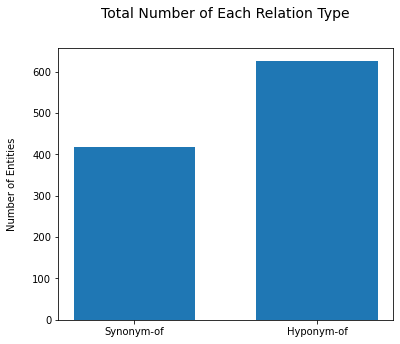

In [53]:
plt111, ax111 = plt.subplots(figsize = (6, 5))
ax111.bar([0, 0.15], relationsCounter[1:], width = 0.1)
ax111.set_title("Total Number of Each Relation Type", size = 14, pad = 30)
ax111.set_ylabel("Number of Entities", labelpad = 15)
ax111.set_xticks([0, 0.15])
trash = ax111.set_xticklabels(["Synonym-of", "Hyponym-of"])
plt111.savefig("./CourseworkPlots/totalNumberOfEachRelationType.png")

In [54]:
from nltk.parse.corenlp import CoreNLPServer, CoreNLPParser
from nltk.parse.corenlp import CoreNLPDependencyParser
import os

STANFORD = "./stanford-corenlp-4.2.0"

server = CoreNLPServer(
   os.path.join(STANFORD, "stanford-corenlp-4.2.0.jar"),
   os.path.join(STANFORD, "stanford-corenlp-4.2.0-models.jar"),    
)

server.start()

dep_parser = CoreNLPDependencyParser()

In [55]:
def extractRelationWithDependencyParse(doc, relation, numberOfRelation):#, sentences):
    features = {}
    
    sourceTuple = get_entity_span_from_B_index(doc, relation[numberOfRelation][1])
    source = " ".join([word for word, label in sourceTuple])
    #if source[-1] == "." or source[-1] == ",":
    #    source = source[ : -1]
    targetTuple = get_entity_span_from_B_index(doc, relation[numberOfRelation][2])
    target = " ".join([word for word, label in targetTuple])
    #if target[-1] == "." or target[-1] == ",":
    #    target = target[ : -1]
    
    #print("SOURCE: ", source, "\nTARGET: ", target)
    
    features['source_entity'] = source.replace(" ", "_")
    features['target_entity'] = target.replace(" ", "_")
    
    posTaggedDoc = nltk.pos_tag([word for word, label in doc])
    
    features['source_pos'] = posTaggedDoc[relation[numberOfRelation][1]][1]
    features['target_pos'] = posTaggedDoc[relation[numberOfRelation][2]][1]
    
    features["source_ner"] = sourceTuple[0][1].replace("B-", "")
    features["target_ner"] = targetTuple[0][1].replace("B-", "")
    
    document = " ".join([word for word, label in doc])
    sent = document.replace('%', 'percent')
    
    parsed = False
    while not parsed:
        try:

            parse_tree = [tree for tree in dep_parser.raw_parse(sent)][0]
            parsed = True
        except Exception as e:
            print(doc)
            print(e)
            server.stop()
            server.start()
    
    # traverse up the tree
    nodes_on_path0 = []
    current_node = parse_tree.nodes[relation[numberOfRelation][1] + 1]
    #print(relation[numberOfRelation][0], ":", relation[numberOfRelation][] + 1)
    
    while current_node['address'] != relation[numberOfRelation][2] + 1 and current_node['head'] is not None:
        current_node = parse_tree.nodes[current_node['head']]
        nodes_on_path0.append(current_node['address'])
    
    nodes_on_path1 = []
    current_node = parse_tree.nodes[relation[numberOfRelation][2] + 1]
    while current_node['address'] != relation[numberOfRelation][1] + 1 and current_node['head'] is not None:
        current_node = parse_tree.nodes[current_node['head']]   
        nodes_on_path1.append(current_node['address'])
    
    join_node_i = len(nodes_on_path0) - 1
    join_node_j = len(nodes_on_path1) - 1
    for i, node in enumerate(nodes_on_path0):
        if node in nodes_on_path1:
            join_node_i = i
            join_node_j = np.argwhere(np.array(nodes_on_path1) == node).flatten()[0]
            break
    
    dep_path_source = []
    for node in nodes_on_path0[:join_node_i]:
        dep_path_source.append(parse_tree.nodes[node]['rel'])
        
    features['dep_path_source'] = "_".join(dep_path_source)
        
    dep_path_target = []
    for node in nodes_on_path1[:join_node_j]:
        dep_path_target.append(parse_tree.nodes[node]['rel'])
        
    features['dep_path_target'] = "_".join(dep_path_target)
    
    features['dep_path_length'] = join_node_i + join_node_j
    
    
    label = relation[numberOfRelation][0]
    
    return features, label

def extractRelationWithoutDependencyParse(doc, relation, numberOfRelation):#, sentences):
    features = {}
    
    sourceTuple = get_entity_span_from_B_index(doc, relation[numberOfRelation][1])
    source = " ".join([word for word, label in sourceTuple])
    #if source[-1] == "." or source[-1] == ",":
    #    source = source[ : -1]
    targetTuple = get_entity_span_from_B_index(doc, relation[numberOfRelation][2])
    target = " ".join([word for word, label in targetTuple])
    #if target[-1] == "." or target[-1] == ",":
    #    target = target[ : -1]
    
    #print("SOURCE: ", source, "\nTARGET: ", target)
    
    features['source_entity'] = source.replace(" ", "_")
    features['target_entity'] = target.replace(" ", "_")
    
    posTaggedDoc = nltk.pos_tag([word for word, label in doc])
    
    features['source_pos'] = posTaggedDoc[relation[numberOfRelation][1]][1]
    features['target_pos'] = posTaggedDoc[relation[numberOfRelation][2]][1]            

    features["source_ner"] = sourceTuple[0][1].replace("B-", "")
    features["target_ner"] = targetTuple[0][1].replace("B-", "")
    
    label = relation[numberOfRelation][0]
    
    return features, label

def extractRelationsFromDocsWithDependencyParse(docs, rels):
    relations = []
    for i, doc in enumerate(docs):
        #docRelations = []
        for j in range(len(rels[i])):
            #print(i, j)
            if i == 0:
                relations.append(extractRelationWithDependencyParse(doc, rels[i], j))#, devSentList[ : devDocToSentIndex[0]]))
            elif i == len(docs):
                relations.append(extractRelationWithDependencyParse(doc, rels[i], j))#, devSentList[devDocToSentIndex[i - 1] : ]))
            else:
                relations.append(extractRelationWithDependencyParse(doc, rels[i], j))#, devSentList[devDocToSentIndex[i - 1] : devDocToSentIndex[i]]))
        #relations.append(docRelations)
    return relations

def extractRelationsFromDocsWithoutDependencyParse(docs, rels):
    relations = []
    for i, doc in enumerate(docs):
        #docRelations = []
        for j in range(len(rels[i])):
            #print(i, j)
            if i == 0:
                relations.append(extractRelationWithoutDependencyParse(doc, rels[i], j))#, devSentList[ : devDocToSentIndex[0]]))
            elif i == len(docs):
                relations.append(extractRelationWithoutDependencyParse(doc, rels[i], j))#, devSentList[devDocToSentIndex[i - 1] : ]))
            else:
                relations.append(extractRelationWithoutDependencyParse(doc, rels[i], j))#, devSentList[devDocToSentIndex[i - 1] : devDocToSentIndex[i]]))
        #relations.append(docRelations)
    return relations

In [56]:
# because the way the indexes are set in the original documents
# it is difficult to use the sentences to extract the relations
# nltk library tokenizes differently than the index of the given relations
# therefore we will use the already labelled docs
trainRelationsWithoutDependencyParse = extractRelationsFromDocsWithoutDependencyParse(trainDocs, trainRelations)
devRelationsWithoutDependencyParse = extractRelationsFromDocsWithoutDependencyParse(devDocs, devRelations)
testRelationsWithoutDependencyParse = extractRelationsFromDocsWithoutDependencyParse(testDocs, testRelations)

trainRelationsWithDependencyParse = extractRelationsFromDocsWithDependencyParse(trainDocs, trainRelations)
devRelationsWithDependencyParse = extractRelationsFromDocsWithDependencyParse(devDocs, devRelations)
testRelationsWithDependencyParse = extractRelationsFromDocsWithDependencyParse(testDocs, testRelations)

In [57]:
classifierWithoutDependencyParse = nltk.NaiveBayesClassifier.train(trainRelationsWithoutDependencyParse)
classifierWithDependencyParse = nltk.NaiveBayesClassifier.train(trainRelationsWithDependencyParse)

In [58]:
devRelationsWithNoLabelsWithoutDependencyParse = [rel for rel, lab in devRelationsWithoutDependencyParse]
devRelationsWithNoLabelsWithDependencyParse = [rel for rel, lab in devRelationsWithDependencyParse]

testRelationsWithNoLabelsWithoutDependencyParse = [rel for rel, lab in testRelationsWithoutDependencyParse]
testRelationsWithNoLabelsWithDependencyParse = [rel for rel, lab in testRelationsWithDependencyParse]

devGoldLabels = [lab for rel, lab in devRelationsWithoutDependencyParse]
testGoldLabels = [lab for rel, lab in testRelationsWithoutDependencyParse]

In [59]:
devPredLabelsWithoutDependencyParse = classifierWithoutDependencyParse.classify_many(devRelationsWithNoLabelsWithoutDependencyParse)
devPredLabelsWithDependencyParse = classifierWithDependencyParse.classify_many(devRelationsWithNoLabelsWithDependencyParse)

In [60]:
from sklearn.metrics import f1_score

print("F1 without dependency parse:", f1_score(devGoldLabels, devPredLabelsWithoutDependencyParse, average = "macro"))
print("F1 with dependency parse:", f1_score(devGoldLabels, devPredLabelsWithDependencyParse, average = "macro"))

F1 without dependency parse: 0.7080386371903165
F1 with dependency parse: 0.7021645021645022


In [61]:
print("F1 without dependency parse:", f1_score(devGoldLabels, devPredLabelsWithoutDependencyParse, labels = ["Synonym-of", "Hyponym-of"], average = None))
print("F1 with dependency parse:", f1_score(devGoldLabels, devPredLabelsWithDependencyParse, labels = ["Synonym-of", "Hyponym-of"], average = None))

F1 without dependency parse: [0.60550459 0.81057269]
F1 with dependency parse: [0.59047619 0.81385281]


In [62]:
f1ScoreWithAndWithoutDependencyParse = [f1_score(devGoldLabels, devPredLabelsWithDependencyParse, average = "macro"), f1_score(devGoldLabels, devPredLabelsWithoutDependencyParse, average = "macro")]

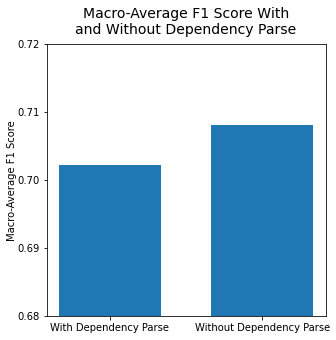

In [63]:
plt222, ax222 = plt.subplots(figsize = (5, 5))
ax222.bar([0, 0.15], f1ScoreWithAndWithoutDependencyParse, width = 0.1)
ax222.set_title("Macro-Average F1 Score With\nand Without Dependency Parse", size = 14, pad = 10)
ax222.set_ylabel("Macro-Average F1 Score", labelpad = 0)
ax222.set_ylim([0.68, 0.72])
ax222.set_yticks([x/100 for x in range(68, 73)])
ax222.set_xticks([0, 0.15])
trash = ax222.set_xticklabels(["With Dependency Parse", "Without Dependency Parse"])
plt222.savefig("./CourseworkPlots/f1ScoreWithAndWithoutDependencyParse.png")

In [64]:
server.stop()

In [65]:
classifier = nltk.NaiveBayesClassifier.train(trainRelationsWithoutDependencyParse)

In [66]:
testPredLabels = classifier.classify_many(testRelationsWithNoLabelsWithoutDependencyParse)

In [67]:
f1_score(testGoldLabels, testPredLabels, average = "macro")

0.7313086575978067

In [68]:
f1_score(testGoldLabels, testPredLabels, labels = ["Synonym-of", "Hyponym-of"], average = None)

array([0.76146789, 0.70114943])

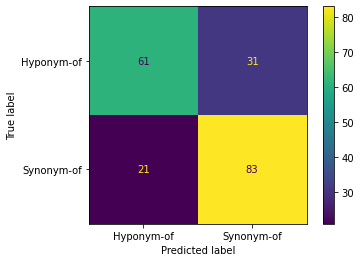

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

trash = ConfusionMatrixDisplay(confusion_matrix(testGoldLabels, testPredLabels), display_labels = ["Hyponym-of", "Synonym-of"]).plot()

In [70]:
def printLabelErrors(goldLabels, predLabels, originalList, docs):
    
    totalErrors = 0
    for i, goldLabel in enumerate(goldLabels):
        if goldLabel != predLabels[i]:
            totalErrors += 1
    
    print("Total Errors:", totalErrors, "out of", len(originalList), "cases (" + str(round(totalErrors/len(originalList), 4)) + "%)")
    print("")
    
    errors = []
    for i, goldLabel in enumerate(goldLabels):
        if goldLabel != predLabels[i]:
            sourceTuple = get_entity_span_from_B_index(testDocs[originalList[i][0]], originalList[i][1][1])
            source = " ".join([word for word, label in sourceTuple])
            targetTuple = get_entity_span_from_B_index(testDocs[originalList[i][0]], originalList[i][1][2])
            target = " ".join([word for word, label in targetTuple])
#             print(originalList[i])
            errors.append([source, predLabels[i], target, goldLabel])
#             print(source, "--" + predLabels[i] + "-->", target)
#             print("Correct Label:", goldLabel)
#             print("")
    
    tempSameSourceErrors = np.unique([elem[0] for elem in errors]).tolist()
    tempSameTargetErrors = np.unique([elem[2] for elem in errors]).tolist()
    sumSameSourceErrors = []
    for sourceError in tempSameSourceErrors:
        sumSameSourceErrors.append([sourceError, 0])
    sumSameTargetErrors = []
    for targetError in tempSameTargetErrors:
        sumSameTargetErrors.append([targetError, 0])
#     sumSameSourceErrors = [[source, 0] for source in sumSameSourceErrors]
#     sumSameTargetErrors = [[tag, 0] for tag in sumSameTargetErrors]
#    print(sumSameSourceErrors)
    for error in errors:
        for index, (source, number) in enumerate(sumSameSourceErrors):
            if source == error[0]:
                sumSameSourceErrors[index] = [source, number + 1]
                break
        for index, (target, number) in enumerate(sumSameTargetErrors):
            if target == error[2]:
                sumSameTargetErrors[index] = [target, number + 1]
                break
    
    maxNumberSameSourceErrors = max([number for sourceError, number in sumSameSourceErrors])
    maxNumberSameTargetErrors = max([number for targetError, number in sumSameTargetErrors])
    sourceWithMostErrors = []
    targetWithMostErrors = []
    for sourceError, number in sumSameSourceErrors:
        if number == maxNumberSameSourceErrors:
            sourceWithMostErrors = sourceError
            break
    for targetError, number in sumSameTargetErrors:
        if number == maxNumberSameTargetErrors:
            targetWithMostErrors = targetError
            break
    
    entitiesAsSources = []
    for numberOfDoc, relation in originalList:
        sourceTuple = get_entity_span_from_B_index(testDocs[numberOfDoc], relation[1])
        source = " ".join([word for word, label in sourceTuple])
        entitiesAsSources.append(source)
    
    entitiesAsTargets = []
    for numberOfDoc, relation in originalList:
        targetTuple = get_entity_span_from_B_index(testDocs[numberOfDoc], relation[2])
        target = " ".join([word for word, label in targetTuple])
        entitiesAsTargets.append(target)
    
    numberOfTargetAsTargetEntity = 0
    numberOfSourceAsTargetEntity = 0
    for entity in entitiesAsTargets:
        if entity == sourceWithMostErrors:
            numberOfSourceAsTargetEntity += 1
        if entity == targetWithMostErrors:
            numberOfTargetAsTargetEntity += 1
            
    numberOfSourceAsSourceEntity = 0      
    numberOfTargetAsSourceEntity = 0
    for entity in entitiesAsSources:
        if entity == targetWithMostErrors:
            numberOfTargetAsSourceEntity += 1
        if entity == sourceWithMostErrors:
            numberOfSourceAsSourceEntity += 1
    
    print("Source entity with the most wrong predictions:", sourceWithMostErrors, "(" + str(maxNumberSameSourceErrors) + " out of", numberOfSourceAsSourceEntity, "total occurences)")
    print("")    
    for error in errors:
        if error[0] == sourceWithMostErrors:
            print(error[0], "-- " + error[1] + " -->", error[2])
            print("Correct Label:", error[3])
            print("")
            
    print("                ----------------------------------------")
    print("")
    tempSourceAsTarget = []
    for error in errors:
        if error[2] == sourceWithMostErrors:
            tempSourceAsTarget.append(error)
    
    print("Errors with source entity as target entity:", sourceWithMostErrors, "(" + str(len(tempSourceAsTarget)), "out of", numberOfSourceAsTargetEntity, "total occurences)")
    print("") 
    for error in tempSourceAsTarget:
        print(error[0], "-- " + error[1] + " -->", error[2])
        print("Correct Label:", error[3])
        print("")
    
    print("                ----------------------------------------")
    print("")
    print("Target entity with the most wrong predictions:", targetWithMostErrors, "(" + str(maxNumberSameTargetErrors) + " out of", numberOfTargetAsTargetEntity, "total occurences)")
    print("")    
    for error in errors:
        if error[2] == targetWithMostErrors:
            print(error[0], "-- " + error[1] + " -->", error[2])
            print("Correct Label:", error[3])
            print("")
    
    print("                ----------------------------------------")
    print("") 
    tempTargetAsSource = []
    for error in errors:
        if error[0] == targetWithMostErrors:
            tempTargetAsSource.append(error)
    
    print("Errors with target entity as source entity:", targetWithMostErrors, "(" + str(len(tempTargetAsSource)), "out of", numberOfTargetAsSourceEntity, "total occurences)")
    print("")
    for error in tempTargetAsSource:
        print(error[0], "-- " + error[1] + " -->", error[2])
        print("Correct Label:", error[3])
        print("")
    

            
            

In [71]:
allTestRelations = []
for numberOfTestDoc in range(len(testRelations)):
    for relationInDoc in testRelations[numberOfTestDoc]:
        allTestRelations.append([numberOfTestDoc, relationInDoc])

In [72]:
printLabelErrors(testGoldLabels, testPredLabels, allTestRelations, testDocs)

Total Errors: 52 out of 196 cases (0.2653%)

Source entity with the most wrong predictions: DEM (2 out of 3 total occurences)

DEM -- Synonym-of --> spatial inputs
Correct Label: Hyponym-of

DEM -- Synonym-of --> fine-resolution ( 3″ or finer ) terrain data bases
Correct Label: Hyponym-of

                ----------------------------------------

Errors with source entity as target entity: DEM (0 out of 0 total occurences)

                ----------------------------------------

Target entity with the most wrong predictions: cetep code (3 out of 3 total occurences)

density functional theory -- Hyponym-of --> cetep code
Correct Label: Synonym-of

DFT -- Hyponym-of --> cetep code
Correct Label: Synonym-of

cetep code -- Hyponym-of --> cetep code
Correct Label: Synonym-of

                ----------------------------------------

Errors with target entity as source entity: cetep code (1 out of 1 total occurences)

cetep code -- Hyponym-of --> cetep code
Correct Label: Synonym-of



# Task 3: Exploring the Data

### 3.1

In [73]:
testRelationsPredictions = []
for i, relation in enumerate(testRelationsWithNoLabelsWithoutDependencyParse):
    testRelationsPredictions.append([relation, testPredLabels[i]])

In [74]:
testRelationsPredictions[0]

[{'source_entity': 'thermal_conductivity',
  'target_entity': 'κ',
  'source_pos': 'JJ',
  'target_pos': 'NNP',
  'source_ner': 'Process',
  'target_ner': 'Process'},
 'Synonym-of']

In [75]:
sourceSpansWithNumberOfDocument = []
for numberOfDoc, doc in enumerate(testDocs):
    for relation in testRelations[numberOfDoc]:
        sourceTuple = get_entity_span_from_B_index(doc, relation[1])
        sourceSpan = " ".join([word for word, label in sourceTuple])
        targetTuple = get_entity_span_from_B_index(doc, relation[2])
        targetSpan = " ".join([word for word, label in targetTuple])
        targetTag = targetTuple[0][1][2:]
        sourceSpansWithNumberOfDocument.append([sourceSpan, relation[0], targetTag, targetSpan, numberOfDoc])
        
len(sourceSpansWithNumberOfDocument)

196

In [76]:
duplicates = []
for i, sourceSpanWithNumberOfDocument1 in enumerate(sourceSpansWithNumberOfDocument):
    for sourceSpanWithNumberOfDocument2 in sourceSpansWithNumberOfDocument[i + 1:]:
        if sourceSpanWithNumberOfDocument1[0] == sourceSpanWithNumberOfDocument2[0] and \
           sourceSpanWithNumberOfDocument1[1] == sourceSpanWithNumberOfDocument2[1] and \
           sourceSpanWithNumberOfDocument1[3] == sourceSpanWithNumberOfDocument2[3]:
            duplicates.append(i)
        elif sourceSpanWithNumberOfDocument1[3] == sourceSpanWithNumberOfDocument2[0] and \
             sourceSpanWithNumberOfDocument1[1] == sourceSpanWithNumberOfDocument2[1] and \
             sourceSpanWithNumberOfDocument1[1] == "Hyponym-of" and \
             sourceSpanWithNumberOfDocument1[0] == sourceSpanWithNumberOfDocument2[3]:
            duplicates.append(i)
            
duplicates

[107, 151, 152, 153]

In [77]:
sourceSpansWithNumberOfDocumentWithoutDuplicates = []
duplicateSourceSpansWithNumberOfDocument = []
for i, sourceSpanWithNumberOfDocument in enumerate(sourceSpansWithNumberOfDocument):
    if i not in duplicates:
        sourceSpansWithNumberOfDocumentWithoutDuplicates.append(sourceSpanWithNumberOfDocument)
    else:
        duplicateSourceSpansWithNumberOfDocument.append(sourceSpanWithNumberOfDocument)
        
len(sourceSpansWithNumberOfDocumentWithoutDuplicates)

192

In [78]:
# sourceSpans = []
# for sourceSpanWithNumberOfDocumentWithoutDuplicates in sourceSpansWithNumberOfDocumentWithoutDuplicates:
#     sourceSpans.append(sourceSpanWithNumberOfDocumentWithoutDuplicates[0])
counterForRelation0 = 0
for sourceSpanWithNumberOfDocumentWithoutDuplicates in sourceSpansWithNumberOfDocumentWithoutDuplicates:
    if sourceSpanWithNumberOfDocumentWithoutDuplicates[0] == sourceSpansWithNumberOfDocumentWithoutDuplicates[0][0]:
        counterForRelation0 += 1
        print(str(counterForRelation0) + ".", sourceSpanWithNumberOfDocumentWithoutDuplicates[0], "--", sourceSpanWithNumberOfDocumentWithoutDuplicates[1], "-->", sourceSpanWithNumberOfDocumentWithoutDuplicates[3], "(" + sourceSpanWithNumberOfDocumentWithoutDuplicates[2] + ")")
    elif sourceSpanWithNumberOfDocumentWithoutDuplicates[3] == sourceSpansWithNumberOfDocumentWithoutDuplicates[0][0]:
        counterForRelation0 += 1
        print(str(counterForRelation0) + ".", sourceSpanWithNumberOfDocumentWithoutDuplicates[0], "--", sourceSpanWithNumberOfDocumentWithoutDuplicates[1], "-->", sourceSpanWithNumberOfDocumentWithoutDuplicates[3], "(" + sourceSpanWithNumberOfDocumentWithoutDuplicates[2] + ")")

1. thermal conductivity -- Synonym-of --> κ (Process)


In [79]:
sourceSpans = []
for sourceSpanWithNumberOfDocument in sourceSpansWithNumberOfDocument:
    sourceSpans.append(sourceSpanWithNumberOfDocument[0])

In [80]:
sourceSpansWithNumberOfOccurences = []
for sourceSpan in np.unique(sourceSpans):
    sourceSpansWithNumberOfOccurences.append([sourceSpan, sourceSpans.count(sourceSpan)])
    
sourceSpansWithNumberOfOccurences.sort(key = lambda x : -x[1])

In [81]:
sourceSpansWithNumberOfOccurences[:10]

[['DEM', 3],
 ['CoPi', 2],
 ['ER', 2],
 ['Eyeball Search', 2],
 ['FabHemeLB', 2],
 ['LBP', 2],
 ['SRTM', 2],
 ['atom transfer radical polymerization', 2],
 ['cetyltrimethylammonium bromide', 2],
 ['density functional theory', 2]]

In [82]:
topTenRelations = []
counter = 0
for sourceSpanWithNumberOfOccurences in sourceSpansWithNumberOfOccurences:
    for sourceSpanWithNumberOfDocument in sourceSpansWithNumberOfDocument:
        if sourceSpanWithNumberOfDocument[0] == sourceSpanWithNumberOfOccurences[0]:
            topTenRelations.append(sourceSpanWithNumberOfDocument[:4])
            counter += 1
    if counter >= 10:
        break
        
for relation in topTenRelations:
    print(relation)

['DEM', 'Hyponym-of', 'Process', 'spatial inputs']
['DEM', 'Synonym-of', 'Process', 'Digital Elevation Model']
['DEM', 'Hyponym-of', 'Process', 'fine-resolution ( 3″ or finer ) terrain data bases']
['CoPi', 'Synonym-of', 'Material', 'CoPOx']
['CoPi', 'Hyponym-of', 'Material', 'co-catalyst']
['ER', 'Hyponym-of', 'Process', 'eye location method']
['ER', 'Hyponym-of', 'Process', 'eye location method']
['Eyeball Search', 'Synonym-of', 'Process', 'ER']
['Eyeball Search', 'Synonym-of', 'Process', 'ER']
['FabHemeLB', 'Hyponym-of', 'Material', 'Python tool']
['FabHemeLB', 'Hyponym-of', 'Material', 'FabSim']


In [83]:
topTenRelationsWithoutDuplicates = []
for i, relation1 in enumerate(topTenRelations):
    duplicate = False
    for relation2 in topTenRelations[i + 1 :]:
        if relation1 == relation2:
            duplicate = True
    if not duplicate:
        topTenRelationsWithoutDuplicates.append(relation1)

for relation in topTenRelationsWithoutDuplicates:
    print(relation)

['DEM', 'Hyponym-of', 'Process', 'spatial inputs']
['DEM', 'Synonym-of', 'Process', 'Digital Elevation Model']
['DEM', 'Hyponym-of', 'Process', 'fine-resolution ( 3″ or finer ) terrain data bases']
['CoPi', 'Synonym-of', 'Material', 'CoPOx']
['CoPi', 'Hyponym-of', 'Material', 'co-catalyst']
['ER', 'Hyponym-of', 'Process', 'eye location method']
['Eyeball Search', 'Synonym-of', 'Process', 'ER']
['FabHemeLB', 'Hyponym-of', 'Material', 'Python tool']
['FabHemeLB', 'Hyponym-of', 'Material', 'FabSim']


In [84]:
print("Unique relations displayed:", len(topTenRelationsWithoutDuplicates),"\nTotal relations:           ", len(topTenRelations))
print("")

maxSourceSpanLength = max([len(relation[0]) for relation in topTenRelationsWithoutDuplicates])
maxTargetSpanLength = max([len(relation[3]) for relation in topTenRelationsWithoutDuplicates])
maxEntityTypeLength = max([len(relation[2]) for relation in topTenRelationsWithoutDuplicates])

print("Source Span" + " " * (maxSourceSpanLength - len("Source Span") + 6) + "Relation" + " " * 7 + "Target Span" + " " * (maxTargetSpanLength - len("Relation") ) + "NER" + " " * (maxEntityTypeLength - len("NER") + 5) + "Occurs")
print("")

for relation in topTenRelationsWithoutDuplicates:
    sourceSpanLength = maxSourceSpanLength - len(relation[0]) + 1
    sourceTargetLength = maxTargetSpanLength - len(relation[3]) + 1
    sourceEntityTypeLength = maxEntityTypeLength - len(relation[2]) + 1
    counter = 1
    for duplicate in duplicateSourceSpansWithNumberOfDocument:
        if relation == duplicate[:4]:
            counter += 1
    print("\"" + relation[0] + "\"" + " " * sourceSpanLength + "--", relation[1], "-->", "\"" + relation[3] + "\"" + " " * sourceTargetLength + "(" + relation[2] + ")" + " " * sourceEntityTypeLength + "|", str(counter), "time(s)")
    print("")

Unique relations displayed: 9 
Total relations:            11

Source Span         Relation       Target Span                                          NER          Occurs

"DEM"            -- Hyponym-of --> "spatial inputs"                                     (Process)  | 1 time(s)

"DEM"            -- Synonym-of --> "Digital Elevation Model"                            (Process)  | 1 time(s)

"DEM"            -- Hyponym-of --> "fine-resolution ( 3″ or finer ) terrain data bases" (Process)  | 1 time(s)

"CoPi"           -- Synonym-of --> "CoPOx"                                              (Material) | 1 time(s)

"CoPi"           -- Hyponym-of --> "co-catalyst"                                        (Material) | 1 time(s)

"ER"             -- Hyponym-of --> "eye location method"                                (Process)  | 2 time(s)

"Eyeball Search" -- Synonym-of --> "ER"                                                 (Process)  | 2 time(s)

"FabHemeLB"      -- Hyponym-of --> "Python t

### 3.2

In [85]:
documentToCheck = -1
for sourceSpanWithNumberOfDocument in sourceSpansWithNumberOfDocument:
    if sourceSpanWithNumberOfDocument[:4] == ['DEM', 'Hyponym-of', 'Process', 'spatial inputs']:
        documentToCheck = sourceSpanWithNumberOfDocument[4]
        break

documentToCheck

29

In [86]:
entitiesOfDocuments = []

for numberOfDocument, doc in enumerate(testDocs):
    tempEntitiesOfDocument = []
    testSents = []
    if numberOfDocument == 0:
        testSents = testSentList[: testDocToSentIndex[0]]
    elif numberOfDocument == len(testDocs):
        testSents = testSentList[testDocToSentIndex[numberOfDocument] :]
    else:
        testSents = testSentList[testDocToSentIndex[numberOfDocument - 1] : testDocToSentIndex[numberOfDocument]]
    
    for sent in testSents:
        words = []
        wordTag = ""
        entityBoolean = False
        for word, tag in sent:
            if tag[:2] == "B-":
                wordTag = tag[2:]
                words.append(word)
                entityBoolean = True
                continue
            if entityBoolean:
                if tag[:2] == "B-":
                    tempEntitiesOfDocument.append([" ".join(words), wordTag])
                    words = []
                    wordTag = tag
                    words.append(word)
                elif tag == "I-" + wordTag:
                    words.append(word)
                else:
                    tempEntitiesOfDocument.append([" ".join(words), wordTag])
                    words = []
                    wordTag = ""
                    entityBoolean = False
    
    tempTempEntities = []
    for i, relation1 in enumerate(tempEntitiesOfDocument):
        duplicate = False
        for relation2 in tempEntitiesOfDocument[i + 1 :]:
            if relation1 == relation2:
                duplicate = True
        if not duplicate:
            tempTempEntities.append(relation1)
    entitiesOfDocuments.append(tempTempEntities)

len(entitiesOfDocuments) == len(testDocs)

True

In [87]:
dtc = 94
cooccurrences = []
for i in range(len(testDocs)):
    entitiesOfOtherDocuments = []
    if i == 0:
        entitiesOfOtherDocuments = entitiesOfDocuments[1 : ]
    elif i == len(testDocs):
        entitiesOfOtherDocuments = entitiesOfDocuments[i : ]
    else:
        entitiesOfOtherDocuments = entitiesOfDocuments[ : i] + entitiesOfDocuments[i + 1 :]

    #entitiesOfOtherDocuments = entitiesOfDocuments[i + 1 : ]
    
    for word, tag in entitiesOfDocuments[i]:
        for j, entitiesOfOtherDocument in enumerate(entitiesOfOtherDocuments):
            for otherWord, otherTag in entitiesOfOtherDocument:
                if word == otherWord:
                    k = j# + i + 1
                    if k >= i:
                        k += 1
                    cooccured = False
                    for z, cooccurrence in enumerate(cooccurrences):
                        if cooccurrence[0] == word and cooccurrence[1] == i:
                            cooccured = True
                            alreadyInList = False
                            for v in range(4, len(cooccurrence), 2):
                                if cooccurrence[v - 1] == k and cooccurrence[v] == otherTag:
                                    alreadyInList = True
                            if not alreadyInList:
                                cooccurrences[z].append(k)
                                cooccurrences[z].append(otherTag)
                            break
                    if not cooccured:
                        cooccurrences.append([word, i, tag, k, otherTag])
                    #print(i, "and", k, ":", word, "(" + tag + ")", "(" + otherTag + ")")

In [88]:
# for cooc in cooccurrences:
#     print(cooc)

In [89]:
pairsOfCooccurrences = []
cooccurrencesInTheSameDocument = []
for i in range(len(testDocs)):
    documentOccurrences = []
    for occurrences in cooccurrences:
        if occurrences[1] == i:
            documentOccurrences.append(occurrences)
    if len(documentOccurrences) > 1:
        #print(documentOccurrences)
        for j, occurrence1 in enumerate(documentOccurrences):
            #print("OCCUR1", occurrence1)
            for occurrence2 in documentOccurrences[j + 1 :]:
                #print("OCCUR2", occurrence2)
                word1 = occurrence1[0]
                word2 = occurrence2[0]
                occurrencesToDocs1 = [occurrence1[h] for h in range(3, len(occurrence1), 2)]
                occurrencesToDocs2 = [occurrence2[h] for h in range(3, len(occurrence2), 2)]
                for occurrenceToDoc1 in occurrencesToDocs1:
                    if occurrenceToDoc1 in occurrencesToDocs2:
                        pairsOfCooccurrences.append([occurrence1, occurrence2])
                        print("FIND CO-OCCURRENCE", occurrence1[1], occurrenceToDoc1)
                        cooccurrencesInTheSameDocument.append([occurrence1[1], documentOccurrences])
                        
len(pairsOfCooccurrences)

FIND CO-OCCURRENCE 60 71
FIND CO-OCCURRENCE 71 60


2

In [90]:
uniquePairsOfCooccurrences = []
for pairOfCooccurrences in pairsOfCooccurrences:
    occur1 = pairOfCooccurrences[0]
    occur2 = pairOfCooccurrences[1]
    entity1 = occur1[0]
    entity2 = occur2[0]
    isUnique = True
    for uniquePairOfCooccurrences in uniquePairsOfCooccurrences:
        uOccur1 = uniquePairOfCooccurrences[0]
        uOccur2 = uniquePairOfCooccurrences[1]
        uEntity1 = uOccur1[0]
        uEntity2 = uOccur2[0]
        if (entity1 == uEntity1 or entity1 == uEntity2) and (entity2 == uEntity1 or entity2 == uEntity2):
            isUnique = False
            break
    if isUnique:
        uniquePairsOfCooccurrences.append(pairOfCooccurrences)

len(uniquePairsOfCooccurrences)

1

Found 1 unique pair of entities that co-occur in multiple abstracts.

Entity "atom transfer radical polymerization" (Process) and entity "ATRP" (Process) are both in documents 60 and 71



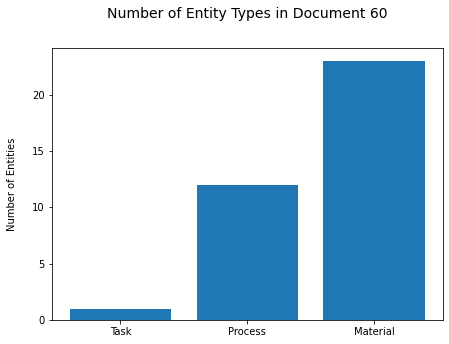

In [91]:
print("Found", len(uniquePairsOfCooccurrences), "unique pair of entities that co-occur in multiple abstracts.")
print("")
for uniquePairOfCooccurrences in uniquePairsOfCooccurrences:
    
    otherDocumentNumbers1 = []
    for i in range(3, len(uniquePairOfCooccurrences[0]), 2):
        otherDocumentNumbers1.append(uniquePairOfCooccurrences[0][i])
    
    otherDocumentNumbers2 = []
    for i in range(3, len(uniquePairOfCooccurrences[1]), 2):
        otherDocumentNumbers2.append(uniquePairOfCooccurrences[1][i])
    
    otherDocumentNumber = list(set(otherDocumentNumbers1).intersection(otherDocumentNumbers2))[0]
    
    print("Entity", "\"" + uniquePairOfCooccurrences[0][0] + "\"", "(" + uniquePairOfCooccurrences[0][2] + ")", \
          "and entity", "\"" + uniquePairOfCooccurrences[1][0] + "\"", "(" + uniquePairOfCooccurrences[1][2] + ")", \
          "are both in documents", uniquePairOfCooccurrences[0][1], "and", otherDocumentNumber)

print("")
entityTypesInTheDocument = []
for i in range(3):
    entityTypesInTheDocument.append(0)

for entity, tag in entitiesOfDocuments[uniquePairsOfCooccurrences[0][0][1]]:
    if tag == "Task":
        entityTypesInTheDocument[0] = entityTypesInTheDocument[0] + 1
    elif tag == "Process":
        entityTypesInTheDocument[1] = entityTypesInTheDocument[1] + 1
    elif tag == "Material":
        entityTypesInTheDocument[2] = entityTypesInTheDocument[2] + 1
        
plt444, ax444 = plt.subplots(figsize = (7, 5))
ax444.bar(range(3), entityTypesInTheDocument)
ax444.set_title("Number of Entity Types in Document " + str(uniquePairsOfCooccurrences[0][0][1]), size = 14, pad = 30)
ax444.set_ylabel("Number of Entities", labelpad = 15)
ax444.set_xticks(range(3))
trash = ax444.set_xticklabels(["Task", "Process", "Material"])
plt444.savefig("./CourseworkPlots/entityTypesInDocument.png")

# Task 4

### 4.2

In [92]:
trainRelationsWithoutDependencyParse[0]

({'source_entity': 'baryons',
  'target_entity': 'complimentary_probe',
  'source_pos': 'NNS',
  'target_pos': 'JJ',
  'source_ner': 'Material',
  'target_ner': 'Material'},
 'Hyponym-of')

In [93]:
def removePOSTagsFromDictionary(dictionary):
    
    newDict = {}
    newDict["source"] = dictionary["source_entity"]
    newDict["target"] = dictionary["target_entity"]
    newDict["sourceNER"] = dictionary["source_ner"]
    newDict["targetNER"] = dictionary["target_ner"]
    
    return newDict

trainRelationsWithoutPOSTags = []
for relation, tag in trainRelationsWithoutDependencyParse:
    trainRelationsWithoutPOSTags.append((removePOSTagsFromDictionary(relation), tag))

devRelationsWithNoLabelsWithoutPOSTags = []
for relation, tag in devRelationsWithoutDependencyParse:
    devRelationsWithNoLabelsWithoutPOSTags.append(removePOSTagsFromDictionary(relation))
    
testRelationsWithNoLabelsWithoutPOSTags = []
for relation, tag in testRelationsWithoutDependencyParse:
    testRelationsWithNoLabelsWithoutPOSTags.append(removePOSTagsFromDictionary(relation))

In [94]:
from nltk.classify import SklearnClassifier
from sklearn.svm import SVC

svcF1ScoreWithoutPOSTags = []
kernels = ["linear", "poly", "rbf", "sigmoid"]
for kernel in kernels:
    svc = SklearnClassifier(SVC(kernel = kernel, random_state = 9052021), sparse = False).train(trainRelationsWithoutPOSTags)
    svcPreds = svc.classify_many(devRelationsWithNoLabelsWithoutPOSTags)
    svcF1ScoreWithoutPOSTags.append(round(f1_score(devGoldLabels, svcPreds, average = "macro"), 15))

svcF1ScoreWithoutPOSTags

[0.545083457947702, 0.422680412371134, 0.422680412371134, 0.422680412371134]

In [95]:
svcF1ScoreWithPOSTags = []
kernels = ["linear", "poly", "rbf", "sigmoid"]
for kernel in kernels:
    svc = SklearnClassifier(SVC(kernel = kernel, random_state = 9052021), sparse = False).train(trainRelationsWithoutDependencyParse)
    svcPreds = svc.classify_many(devRelationsWithNoLabelsWithoutDependencyParse)
    svcF1ScoreWithPOSTags.append(round(f1_score(devGoldLabels, svcPreds, average = "macro"), 15))

svcF1ScoreWithPOSTags

[0.714285714285714, 0.709621663145766, 0.714285714285714, 0.714285714285714]

In [96]:
svcF1ScoreWithDependencyParse = []
kernels = ["linear", "poly", "rbf", "sigmoid"]
for kernel in kernels:
    svc = SklearnClassifier(SVC(kernel = kernel, random_state = 9052021), sparse = False).train(trainRelationsWithDependencyParse)
    svcPreds = svc.classify_many(devRelationsWithNoLabelsWithDependencyParse)
    svcF1ScoreWithDependencyParse.append(round(f1_score(devGoldLabels, svcPreds, average = "macro"), 15))

svcF1ScoreWithDependencyParse

[0.697548815953469, 0.489097379488839, 0.719986666031716, 0.561396521969999]

In [97]:
print("SVC Validation Macro-Average F1 Score")
print("")
print("Kernel     Without PoS Tags           With PoS Tags        With Dependency Parse")
print("")
maxLengthOfKernel = max([len(kernel) for kernel in kernels])
for i in range(4):
    print(kernels[i] + " " * (maxLengthOfKernel - len(kernels[i]) + 3), svcF1ScoreWithoutPOSTags[i], "      ",svcF1ScoreWithPOSTags[i], "      ",svcF1ScoreWithDependencyParse[i])

SVC Validation Macro-Average F1 Score

Kernel     Without PoS Tags           With PoS Tags        With Dependency Parse

linear     0.545083457947702        0.714285714285714        0.697548815953469
poly       0.422680412371134        0.709621663145766        0.489097379488839
rbf        0.422680412371134        0.714285714285714        0.719986666031716
sigmoid    0.422680412371134        0.714285714285714        0.561396521969999


In [98]:
print(" C     Macro-Average F1 Score")
print("")
for c in [v/10 for v in range(1, 21)]:
    svc = SklearnClassifier(SVC(kernel = kernels[-2], random_state = 9052021), sparse = False).train(trainRelationsWithoutDependencyParse)
    svcPreds = svc.classify_many(devRelationsWithNoLabelsWithoutDependencyParse)
    print(c, "    ", round(f1_score(devGoldLabels, svcPreds, average = "macro"), 15))

 C     Macro-Average F1 Score

0.1      0.714285714285714
0.2      0.714285714285714
0.3      0.714285714285714
0.4      0.714285714285714
0.5      0.714285714285714
0.6      0.714285714285714
0.7      0.714285714285714
0.8      0.714285714285714
0.9      0.714285714285714
1.0      0.714285714285714
1.1      0.714285714285714
1.2      0.714285714285714
1.3      0.714285714285714
1.4      0.714285714285714
1.5      0.714285714285714
1.6      0.714285714285714
1.7      0.714285714285714
1.8      0.714285714285714
1.9      0.714285714285714
2.0      0.714285714285714


In [99]:
svc = SklearnClassifier(SVC(C = 1, kernel = kernels[-2], random_state = 9052021), sparse = False).train(trainRelationsWithoutDependencyParse)
svcPreds = svc.classify_many(testRelationsWithNoLabelsWithoutDependencyParse)
svcF1Score = f1_score(testGoldLabels, svcPreds, average = "macro")
svcF1Score

0.7623115047980598

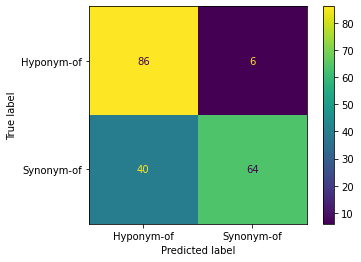

In [100]:
trash = ConfusionMatrixDisplay(confusion_matrix(testGoldLabels, svcPreds), display_labels = ["Hyponym-of", "Synonym-of"]).plot()

In [101]:
printLabelErrors(testGoldLabels, svcPreds, allTestRelations, testDocs)

Total Errors: 46 out of 196 cases (0.2347%)

Source entity with the most wrong predictions: FabHemeLB (2 out of 2 total occurences)

FabHemeLB -- Synonym-of --> Python tool
Correct Label: Hyponym-of

FabHemeLB -- Synonym-of --> FabSim
Correct Label: Hyponym-of

                ----------------------------------------

Errors with source entity as target entity: FabHemeLB (0 out of 0 total occurences)

                ----------------------------------------

Target entity with the most wrong predictions: cetep code (3 out of 3 total occurences)

density functional theory -- Hyponym-of --> cetep code
Correct Label: Synonym-of

DFT -- Hyponym-of --> cetep code
Correct Label: Synonym-of

cetep code -- Hyponym-of --> cetep code
Correct Label: Synonym-of

                ----------------------------------------

Errors with target entity as source entity: cetep code (1 out of 1 total occurences)

cetep code -- Hyponym-of --> cetep code
Correct Label: Synonym-of

